# JiT (Just Image Transformers)

https://arxiv.org/pdf/2511.13720

 JiT argues x-prediction is often preferable because clean data $x$ lies on a low-dimensional manifold (easier for networks to learn), while ε and v span high-dimensional space off-manifold.

 During generation/sampling, transform the network output to the v-space (to solve the ODE $\frac{dz_t}{dt} = v_\theta(z_t, t)$)

 This notebook will implement the toy example from the paper using JAX, training a MLP to generate the SWISS roll embedded in a high AMBIENT dimension, to prove this point.

In [ ]:
N = 10000
def get_spiral_data(batch_size, noise=0.02):
    data, _ = make_swiss_roll(batch_size, noise=noise)
    data = data[:, [0, 2]] / 10.0
    return jnp.array(data)
data = get_spiral_data(N,noise=.5)

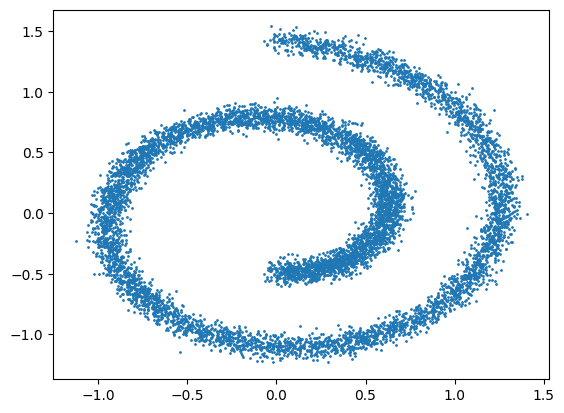

In [13]:
import matplotlib.pyplot as plt
plt.scatter(x=data[:,0],y=data[:,1],s=1.0)

In [14]:
class MLP(eqx.Module):
  layers: list
  t_enc: eqx.Module

  def __init__(self,key,D,t_D=4):
    keys = jax.random.split(key, 6)
    hidden_dim = 256
    szs = [D+t_D] + 4*[hidden_dim] + [D]

    self.t_enc = eqx.nn.Linear(1,t_D,key=keys[0])

    self.layers = []
    for i,(in_dim,out_dim,key) in enumerate(zip(szs[:-1],szs[1:],keys[1:])):
      layer = eqx.nn.Linear(in_dim,out_dim,key = key)
      self.layers.append(layer)

  def __call__(self,x,t):
    t_enc = jax.nn.relu(self.t_enc(t))

    # Concatenate x (D) and t (t_D)
    x = jnp.concatenate([x, t_enc], axis=-1)
    # (B,D+t_d)
    for layer in self.layers[:-1]:
      x = layer(x)
      x = jax.nn.relu(x)
    x = self.layers[-1](x)
    return x

## V-Losses
By parameterizing the network output as an $x$-prediction,$v$-prediction, or $\epsilon$-prediction, we can obtain the other two quantities with the two relevant equations in flow matching.

$$z_t = t x + (1-t) \epsilon$$

$$v = x - \epsilon$$

where $x \sim p_{data}$ and $\epsilon \sim \mathcal{N}(0, I)$.

For example, if we parameterize the network to predict $x$, i.e $x_\theta = \text{net}_\theta (z_t,t)$, the above two equations form consistency conditions that any triplet $x_\theta, \epsilon_\theta, v_\theta$ must satisfy at each timestep. 


$$\begin{cases}
x_\theta = \text{net}_\theta(z_t, t) & (1) \\
z_t = t \, x_\theta + (1 - t) \, \epsilon_\theta & (2) \\
v_\theta = x_\theta - \epsilon_\theta & (3)\\
\end{cases}$$

By consistency conditions, we mean the other two variables ($\epsilon_\theta$ and $v_\theta$) are completely determined by the constraints above.

1) by construction, $x_\theta$ directly from the network.
2) forward-process consistency: whatever clean image $x_\theta$ and noise $\epsilon_\theta$ the model believes in, they must reproduce the actually observed $z_t$ when interpolated
3. velocity-definition consistency: the predicted velocity is defined to be exactly $x - \epsilon$.

We obtain $v_\theta$ by rearranging the second equation and plugging into the third.

$$v_\theta = x_\theta - \frac{z_t - t \, x_\theta}{1 - t} = \frac{x_\theta (1 - t) - (z_t - t \, x_\theta)}{1 - t} = \frac{x_\theta - t \, x_\theta - z_t + t \, x_\theta}{1 - t} = \frac{x_\theta - z_t}{1 - t}$$

Then, we train with our v-loss as normal:
$$L_{v} = \mathbb{E}_{t, x, \epsilon} \left[ \| v_\theta - (x-\epsilon) \|^2 \right]$$

This notebook focuses on the $v$-loss space for simplicity.

In [2]:
def x_pred_v_loss(model,x,z_t,t,eps):
  '''
  model: nn making x-prediction
  x: sampled from p_data
  pred: output of the network
  z_t: the interpolation between x and eps
  t: time step
  eps: noise
  '''
  v_target = x-eps
  x_pred = vmap(model)(z_t,t)
  v_theta = (x_pred - z_t)/(1-t).clip(.01,1-.01)
  return jnp.mean((v_target-v_theta)**2)

def v_pred_v_loss(model,x,z_t,t,eps):
  '''
  model: nn making v-prediction
  x: sampled from p_data
  pred: output of the network
  z_t: the interpolation between x and eps
  t: time step
  eps: noise
  '''
  v_target = x-eps
  v_pred = vmap(model)(z_t,t)
  return jnp.mean((v_target-v_pred)**2)

def eps_pred_v_loss(model,x,z_t,t,eps):
  '''
  model: nn making eps-prediction
  x: sampled from p_data
  pred: output of the network
  z_t: the interpolation between x and eps
  t: time step
  eps: noise
  '''
  v_target = x-eps
  eps_pred = vmap(model)(z_t,t)
  v_theta = (z_t - eps_pred) / t.clip(.05,1-.05)
  return jnp.mean((v_target-v_theta)**2)

## Training Loop

### Slow Training Loop

In [16]:
def logistic(x):
  return 1.0 / (1.0 + jnp.exp(-x))

def make_step(mlp,x,optim, opt_state,key,loss_fn):
  '''
  Compute loss and take gradient step on sampled data
  '''
  step_key, noise_key = random.split(key,2)
  t = random.uniform(step_key,shape=(cfg['batch_size'],1))
  # t = logistic(t)
  t=t.clip(.01,1-.01)
  # (B,1)
  eps = random.normal(noise_key,shape=x.shape)
  # (B, D)
  z_t = t * x + (1-t) * eps
  # (B, D)

  loss_value, grads = eqx.filter_value_and_grad(loss_fn)(mlp, x,z_t,t,eps)

  updates, opt_state = optim.update(
        grads, opt_state, eqx.filter(mlp, eqx.is_array)
    )
  mlp = eqx.apply_updates(mlp, updates)

  return mlp,opt_state,loss_value

def train_model(cfg, key, P, data, pred_type, loss_type = 'v_loss'):
  mlp = MLP(key,cfg['D'])
  optim = optax.adam(cfg['lr'])
  opt_state = optim.init(eqx.filter(mlp, eqx.is_array))

  if pred_type == 'x_prediction':
    loss_fn = x_pred_v_loss
  elif pred_type == 'v_prediction':
    loss_fn = v_pred_v_loss
  elif pred_type == 'eps_prediction':
    loss_fn = eps_pred_v_loss

  @eqx.filter_jit
  def step_fn(mlp, x, opt_state, key):
      return make_step(mlp, x, optim, opt_state, key, loss_fn)

  losses = []
  num_batches = data.shape[0] // cfg['batch_size']
  for step in tqdm(range(cfg['epochs'])):
    key, perm_key = random.split(key,2)
    perm = random.permutation(perm_key, data.shape[0])
    shuffled_data = data[perm]

    epoch_loss = 0
    for i in range(num_batches):
      key, train_key = random.split(key)
      x_hat = shuffled_data[i*cfg['batch_size'] : (i+1)*cfg['batch_size']]
      # (B,2)
      x = x_hat@P.T
      # (B,D)
      mlp, opt_state, train_loss = step_fn(mlp,x,opt_state,train_key)
      epoch_loss += train_loss
    losses.append(epoch_loss/num_batches)

  # print(f"Step={step} Loss={epoch_loss/num_batches}")
  # plt.plot(losses)
  # plt.show()

  return mlp

### Fast Training Loop

In [17]:
def logistic(x):
    return 1.0 / (1.0 + jnp.exp(-x))

# 1. Modified make_step to handle P projection internally and conform to scan signature
def make_step_scanned(carry, batch_data, optim, static_loss_fn, P):
    mlp, opt_state, key = carry
    
    x_hat = batch_data
    
    # projection inside JIT so it's fused and fast
    x = x_hat @ P.T 
    
    step_key, noise_key, next_key = random.split(key, 3)

    t = random.uniform(step_key, shape=(x.shape[0], 1))
    t = t.clip(.01, 1-.01)
    eps = random.normal(noise_key, shape=x.shape)
    z_t = t * x + (1-t) * eps

    loss_value, grads = eqx.filter_value_and_grad(static_loss_fn)(mlp, x, z_t, t, eps)

    updates, opt_state = optim.update(
        grads, opt_state, eqx.filter(mlp, eqx.is_array)
    )
    mlp = eqx.apply_updates(mlp, updates)

    return (mlp, opt_state, next_key), loss_value

def train_model(cfg, key, P, data, pred_type, loss_type='v_loss'):
    mlp = MLP(key, cfg['D'])
    optim = optax.adam(cfg['lr'])
    opt_state = optim.init(eqx.filter(mlp, eqx.is_array))

    if pred_type == 'x_prediction':
        loss_fn = x_pred_v_loss
    elif pred_type == 'v_prediction':
        loss_fn = v_pred_v_loss
    elif pred_type == 'eps_prediction':
        loss_fn = eps_pred_v_loss

    # Calculate batching dimensions
    num_train_samples = data.shape[0]
    # Ensure we drop the last incomplete batch to keep shapes uniform for scan
    num_batches = num_train_samples // cfg['batch_size']
    # Truncate data to fit perfectly into batches
    data_truncated = data[:num_batches * cfg['batch_size']]

    # 2. Define the epoch function (The outer loop)
    def run_epoch(carrier, data_shuffled):
        # Scan automatically iterates over the first dimension of data_shuffled
        # data_shuffled shape: (num_batches, batch_size, input_dim)
        
        final_carrier, losses = jax.lax.scan(
            lambda c, x: make_step_scanned(c, x, optim, loss_fn, P),
            carrier,
            data_shuffled
        )
        return final_carrier, jnp.mean(losses)

    # 3. JIT the ENTIRE epoch loop
    @eqx.filter_jit
    def train_epoch_jit(mlp, opt_state, key, data_epoch):
        # Reshape data to (num_batches, batch_size, features)
        # This effectively "batches" the data for scan
        data_reshaped = data_epoch.reshape(num_batches, cfg['batch_size'], -1)
        
        carrier = (mlp, opt_state, key)
        (mlp, opt_state, key), epoch_loss = run_epoch(carrier, data_reshaped)
        
        return mlp, opt_state, key, epoch_loss

    losses = []
    
    # Main Loop (Python only handles Epochs now)
    for step in tqdm(range(cfg['epochs'])):
        key, perm_key = random.split(key)
        
        perm = random.permutation(perm_key, data_truncated.shape[0])
        shuffled_data = data_truncated[perm]
        
        # Run optimized epoch
        mlp, opt_state, key, epoch_loss = train_epoch_jit(mlp, opt_state, key, shuffled_data)
        
        losses.append(epoch_loss)

    return mlp

## ODE Solvers

In [18]:
# x_{t+h} = x_t + h * v_theta(x,t)
def x_euler_step(model_fn,z,t,dt):
  # z:  (num_samples, D)
  # t:  scalar
  t_vec = jnp.full((1,), t) # (1,)
  x_pred = vmap(model_fn,in_axes=(0,None))(z,t_vec)  # in_axes (0,None) indicates to parallelize over batch, and pass same t
  v_hat = (x_pred - z)/(1-t)
  return z + dt*v_hat,z

# x_{t+h} = x_t + h * v_theta(x,t)
def v_euler_step(model_fn,z,t,dt):
  # z:  (num_samples, D)
  # t:  (num_samples,)
  t_vec = jnp.full((1,), t)
  v_hat = vmap(model_fn,in_axes=(0,None))(z,t_vec)
  return z + dt*v_hat,z

# x_{t+h} = x_t + h * v_theta(x,t)
def eps_euler_step(model_fn,z,t,dt):
  # z:  (num_samples, D)
  # t:  scalar
  t_vec = jnp.full((1,), t) # (1,)
  eps_pred = vmap(model_fn,in_axes=(0,None))(z,t_vec)
  v_hat = (z-eps_pred)/(t)
  return z + dt*v_hat,z

## Train and sample for each D

In [ ]:
from functools import partial
vpreds = []
xpreds = []
eps_preds = []
Ps = []

cfg = {
    'epochs': 2000,
    'batch_size': 1024,
    'lr': 1e-3,
    'D': 2
}

num_samples = 10000
num_steps = 100

key = jax.random.PRNGKey(42)
ts = jnp.linspace(.01,1.0-.01,num_steps)
dt = ts[1] - ts[0]  # Constant step size

d_keys = jax.random.split(key,6)
Ds = [2, 8, 16, 32, 128, 512]
for i in range(len(Ds)):
  d = Ds[i]
  cfg['D'] = d
  # Generate random projection
  A = random.normal(d_keys[i],(cfg['D'], 2))
  # P is a orthonormal projection matrix
  P, _ = jnp.linalg.qr(A)
  P = jnp.array(P)

  print(f"Training x-prediction for dimension {d}")
  mlp_x = train_model(cfg, d_keys[i], P, data, pred_type="x_prediction")
  print(f"Training eps-prediction for dimension {d}")
  mlp_eps = train_model(cfg, d_keys[i], P, data, pred_type="eps_prediction")
  print(f"Training v-prediction for dimension {d}")
  mlp_v = train_model(cfg, d_keys[i], P, data, pred_type="v_prediction")

  x0 = random.normal(d_keys[i],(num_samples,cfg['D']))
  # (num_samples, D)

  step_fn_x = partial(x_euler_step, mlp_x,dt=dt)
  step_fn_eps = partial(eps_euler_step, mlp_eps,dt=dt)
  step_fn_v = partial(v_euler_step, mlp_v,dt=dt)
  
  x1_xpred, history = lax.scan(step_fn_x,init=x0,xs=ts)
  x1_eps_pred, history = lax.scan(step_fn_eps,init=x0,xs=ts)
  x1_vpred, history = lax.scan(step_fn_v,init=x0,xs=ts)

  xpreds.append(x1_xpred)
  eps_preds.append(x1_eps_pred)
  vpreds.append(x1_vpred)
  Ps.append(P)

Training x-prediction for dimension 2


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:08<00:00, 237.22it/s]


Training eps-prediction for dimension 2


100%|██████████| 2000/2000 [00:08<00:00, 235.75it/s]


Training v-prediction for dimension 2


100%|██████████| 2000/2000 [00:08<00:00, 237.53it/s]


Training x-prediction for dimension 8


100%|██████████| 2000/2000 [00:09<00:00, 217.64it/s]


Training eps-prediction for dimension 8


100%|██████████| 2000/2000 [00:08<00:00, 226.43it/s]


Training v-prediction for dimension 8


100%|██████████| 2000/2000 [00:08<00:00, 231.45it/s]


Training x-prediction for dimension 16


100%|██████████| 2000/2000 [00:09<00:00, 216.29it/s]


Training eps-prediction for dimension 16


100%|██████████| 2000/2000 [00:08<00:00, 223.22it/s]


Training v-prediction for dimension 16


100%|██████████| 2000/2000 [00:09<00:00, 220.59it/s]


Training x-prediction for dimension 32


100%|██████████| 2000/2000 [00:08<00:00, 222.66it/s]


Training eps-prediction for dimension 32


100%|██████████| 2000/2000 [00:08<00:00, 226.87it/s]


Training v-prediction for dimension 32


100%|██████████| 2000/2000 [00:08<00:00, 231.21it/s]


Training x-prediction for dimension 128


100%|██████████| 2000/2000 [00:09<00:00, 205.49it/s]


Training eps-prediction for dimension 128


100%|██████████| 2000/2000 [00:09<00:00, 219.97it/s]


Training v-prediction for dimension 128


100%|██████████| 2000/2000 [00:08<00:00, 224.48it/s]


Training x-prediction for dimension 512


100%|██████████| 2000/2000 [00:11<00:00, 178.60it/s]


Training eps-prediction for dimension 512


100%|██████████| 2000/2000 [00:11<00:00, 177.45it/s]


Training v-prediction for dimension 512


100%|██████████| 2000/2000 [00:11<00:00, 178.75it/s]


## Visualize

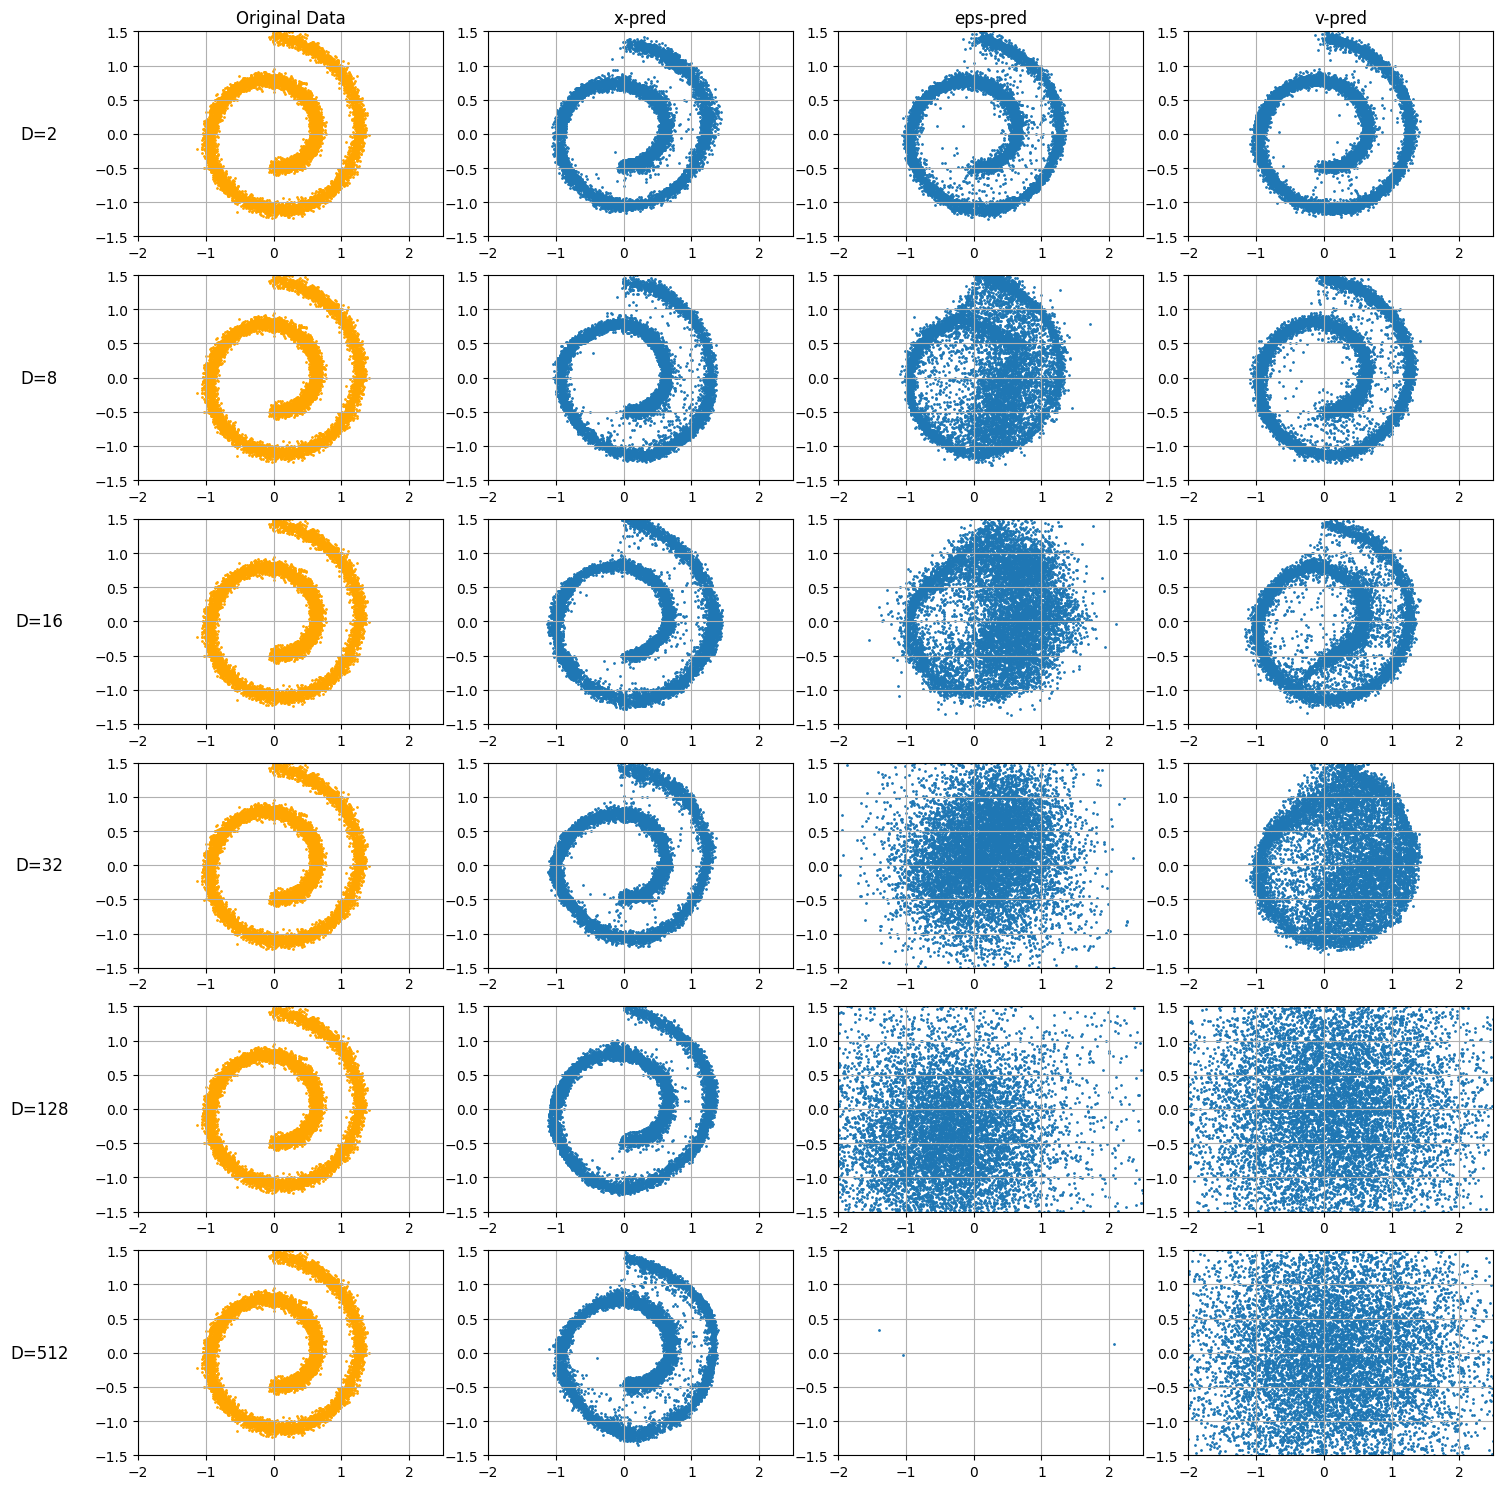

In [20]:
fig, axes = plt.subplots(6, 4, figsize=(15, 15))
column_titles = ["Original Data", "x-pred", "eps-pred", "v-pred"]
for i in range(4):
  axes[0, i].set_title(column_titles[i])

for i in range(6):
  P = Ps[i]
  # left-most subplot shows the original 2D data
  axes[i,0].scatter(data[:,0],data[:,1],s=1.0,c='orange')
  # Horizontal row label showing the latent dimension D
  axes[i,0].set_ylabel(f"D={Ds[i]}", rotation=0, fontsize=12, labelpad=40, va='center')
  # enforce consistent axis limits and grid on each subplot (do this in a small loop to avoid repetition)
  for j in range(4):
    axes[i,j].set_xlim(-2, 2.5)
    axes[i,j].set_ylim(-1.5, 1.5)
    axes[i,j].grid(True)

  x_hat_xpred = xpreds[i] @ P
  axes[i,1].scatter(x_hat_xpred[:,0],x_hat_xpred[:,1],s=1.0)
  x_hat_eps_pred = eps_preds[i] @ P
  axes[i,2].scatter(x_hat_eps_pred[:,0],x_hat_eps_pred[:,1],s=1.0)
  x_hat_vpred = vpreds[i] @ P
  axes[i,3].scatter(x_hat_vpred[:,0],x_hat_vpred[:,1],s=1.0)

# Apply tight layout so labels don't overlap
fig.tight_layout()